In [ ]:
import scipy.io as io
import numpy as np
from detection_XAI.utils import utils
import cv2
from keras.utils import to_categorical

from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

from tensorflow.keras.models import load_model
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from matplotlib.colors import ListedColormap
from scipy.spatial.distance import cdist

# load clustering data
x_train_mat = io.loadmat('./SSL/data/x_cluster.mat')
x_train = x_train_mat['x_cluster']

# labells
y_train_add_mat = io.loadmat('./SSL/data/y_cluster.mat')
y_train_raw = y_train_add_mat['y_cluster']

#pre-processing
y_train = to_categorical(y_train_raw-1)
x_train_n = utils.norml(x_train)
x_train_stft = utils.batch_stft(x_train_n,nfft=128,overlap=0.7)


#reshape input to 64x64
def resize_stft(x_in):
  batch_num = x_in.shape[0]

  # Initialize an empty array to store resized images
  resized_input = np.zeros((batch_num, 64, 64, 3), dtype=np.float32)

  # Loop through each image in the batch and resize
  for i in range(batch_num):
      # Resize each image to (64, 64)
      resized_image = cv2.resize(x_in[i], (64, 64), interpolation=cv2.INTER_LINEAR)

      # Store the resized image in the new array
      resized_input[i] = resized_image


# Now 'resized_images' contains all the images resized to (64, 64, 3) with dtype float32
  return resized_input
def get_k_means_results(saved_encoder_model, x_in, y_test_raw, k=4, vbose = 1):
  # Use the loaded encoder to extract features
  encoded_features = saved_encoder_model.predict(x_in)
  # Initialize the KMeans model
  kmeans = KMeans(n_clusters=k)
  # Reshape the event features for each event
  reshaped_features = encoded_features.reshape(encoded_features.shape[0], -1)
  # Fit the model to data
  kmeans.fit(reshaped_features)
  # Get the cluster assignments for each data point
  cluster_assignments = kmeans.labels_
  # Get the cluster centers
  cluster_centers = kmeans.cluster_centers_

  #post process
  mapped_cluster = cluster_assignments

  if vbose == 1:
    if k == 4:
      target = ['quake','earthquake','rockfall','enviroemnt noise']
      print(classification_report(y_test_raw-1, mapped_cluster, target_names=target))
      print(confusion_matrix(y_test_raw-1, mapped_cluster))
    if k == 3:
      original_array = y_test_raw-1
      # Perform the transformation
      transformed_array = [np.array([0]) if x == 0 or x == 1 else x - 1 for x in original_array]
      target = ['quake and earthquake','rockfall','enviroemnt noise']
      print(classification_report(transformed_array, mapped_cluster, target_names=target, digits=4))
      print(confusion_matrix(transformed_array, mapped_cluster))

  return cluster_assignments, cluster_centers, reshaped_features

def k_means_feature(feature_in, y_test_raw, k=4, vbose = 1):

  # Initialize the KMeans model
  kmeans = KMeans(n_clusters=k)
  # Fit the model to data
  kmeans.fit(feature_in)
  # Get the cluster assignments for each data point
  cluster_assignments = kmeans.labels_
  # Get the cluster centers
  cluster_centers = kmeans.cluster_centers_

  #post process
  mapped_cluster = cluster_assignments

  if vbose == 1:
    if k == 4:
      target = ['quake','earthquake','rockfall','enviroemnt noise']
      print(classification_report(y_test_raw-1, mapped_cluster, target_names=target, digits=4))
      print(confusion_matrix(y_test_raw-1, mapped_cluster))
    if k == 3:
      original_array = y_test_raw-1
      # Perform the transformation
      transformed_array = [np.array([0]) if x == 0 or x == 1 else x - 1 for x in original_array]
      target = ['quake and earthquake','rockfall','enviroemnt noise']
      print(classification_report(transformed_array, mapped_cluster, target_names=target, digits=5))
      print(confusion_matrix(transformed_array, mapped_cluster))

  return cluster_assignments, cluster_centers

def DBSCAN_feature(feature_in, y_test_raw, k=4, eps=0.5, min_samples=5, vbose = 1):

  dbscan = DBSCAN(eps, min_samples)  # Adjust eps and min_samples based on your data
  dbscan.fit(feature_reduced)

  #Access the cluster labels
  labels = dbscan.labels_

  #post process
  mapped_cluster = labels

  if vbose == 1:
    if k == 4:
      target = ['quake','earthquake','rockfall','enviroemnt noise']
      print(classification_report(y_test_raw-1, mapped_cluster, target_names=target, digits=4))
      print(confusion_matrix(y_test_raw-1, mapped_cluster))
    if k == 3:
      original_array = y_test_raw-1
      # Perform the transformation
      transformed_array = [np.array([0]) if x == 0 or x == 1 else x - 1 for x in original_array]
      target = ['quake and earthquake','rockfall','enviroemnt noise']
      print(classification_report(transformed_array, mapped_cluster, target_names=target))
      print(confusion_matrix(transformed_array, mapped_cluster))

  return cluster_assignments

def postprocess_label(cluster_assignments,y_test_raw,x0=0, x1=1, x2=2, x3=3):
  mapped_cluster = np.where(
    cluster_assignments == 0,  # Condition 1: Check if elements in cluster_assignments are equal to 3
    x0,                          # Value to assign if Condition 1 is True (replace with 0)

    np.where(
        cluster_assignments == 1,  # Condition 2: Check if elements in cluster_assignments are equal to 0
        x1,                         # Value to assign if Condition 2 is True (replace with 1)

        np.where(
            cluster_assignments == 2,  # Condition 3: Check if elements in cluster_assignments are equal to 1
            x2,                        # Value to assign if Condition 3 is True (replace with 3)

            np.where(
                cluster_assignments == 3,  # Condition 4: Check if elements in cluster_assignments are equal to 2
                x3,                        # Value to assign if Condition 4 is True (replace with 4)

                cluster_assignments      # Default value if none of the conditions are met
                )
            )
        )
   )
  target = ['quake','earthquake','rockfall','enviroemnt noise']
  print(classification_report(y_test_raw-1, mapped_cluster, target_names=target, digits=4))
  print(confusion_matrix(y_test_raw-1, mapped_cluster))
  return mapped_cluster


def select_label_indices(cluster_centers, percentage, reshaped_features):
    k = len(cluster_centers)

    # Calculate distances from each data point to its assigned cluster centroid
    distances = cdist(reshaped_features, cluster_centers, 'euclidean')

    # Find the closest centroid for each data point
    closest_centroids = np.argmin(distances, axis=1)

    # Initialize a dictionary to store indices of data points closest to each centroid
    cluster_indices = {i: [] for i in range(k)}

    # Populate the dictionary with indices of data points closest to each centroid
    for i, centroid_index in enumerate(closest_centroids):
        cluster_indices[centroid_index].append(i)

    # Initialize a list to store selected indices
    selected_indices = []

    # Iterate over each cluster
    for centroid_index, indices in cluster_indices.items():
        # Calculate the number of data points to select (percentage of the cluster size)
        num_to_select = int(percentage * len(indices))

        # Sort indices based on distances to the centroid
        sorted_indices = sorted(indices, key=lambda x: distances[x, centroid_index])

        # Select the top percentage of indices
        selected_indices.extend(sorted_indices[:num_to_select])

    # Convert selected indices to numpy array
    selected_indices = np.array(selected_indices)

    return selected_indices


def visualize_2d_features(features_2d, clusters_true = y_train_raw.ravel(), title = 'PCA 2-D Visualization'):

    cluster_names = {
    1: 'Quake',
    2: 'Earthquake',
    3: 'Rockfall',
    4: 'Noise'
    }

    colors = ['red', 'blue', 'green', 'orange']

    # Map cluster labels to colors
    cluster_colors = [colors[int(label) - 1] for label in clusters_true]

    # Visualize the t-SNE representation with colored clusters
    plt.scatter(features_2d[:, 0], features_2d[:, 1], c=cluster_colors, cmap='viridis', alpha=0.7)

    # Add labels and title
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.title(title)
    plt.grid(True)

    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in colors]
    labels = [cluster_names[i + 1] for i in range(len(cluster_names))]
    plt.legend(handles, labels, loc='best')

    # Show the plot
    plt.show()

def visualize_3d_features(features_3d, clusters_true, title='PCA 3-D Visualization'):
    cluster_names = {
        1: 'Quake',
        2: 'Earthquake',
        3: 'Rockfall',
        4: 'Noise'
    }

    colors = ['red', 'blue', 'green', 'orange']

    # Map cluster labels to colors
    cluster_colors = [colors[int(label) - 1] for label in clusters_true]

    # Create a 3D plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    sc = ax.scatter(features_3d[:, 0], features_3d[:, 1], features_3d[:, 2], c=cluster_colors, cmap='viridis', alpha=0.7)

    # Add labels and title
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    ax.set_zlabel('Component 3')
    ax.set_title(title)

    # Create custom legend
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in colors]
    labels = [cluster_names[i + 1] for i in range(len(cluster_names))]
    ax.legend(handles, labels, loc='best')

    # Show the plot
    plt.show()

In [ ]:
#load data and SSL model
resized_x_train = resize_stft(x_train_stft)
saved_encoder_model = load_model("./SSL/model/encoder_4x4x16_v2.h5")
#Get features by SSL model
encoded_features = saved_encoder_model.predict(resized_x_train)
reshaped_features = encoded_features.reshape(encoded_features.shape[0], -1)

In [ ]:
#PCA
pca = PCA(n_components=10) # or others
feature_reduced_pca = pca.fit_transform(reshaped_features)
#PCA explained variance analysis
explained_variance_ratio = pca.explained_variance_ratio_
print("Explained variance ratio of each component:", explained_variance_ratio)
print("Sum of Explained variance:", sum(explained_variance_ratio))

Explained variance ratio of each component: [0.42732662 0.20820318 0.16043678 0.06456185 0.03456317 0.02434712
 0.0122943  0.0095705  0.00628196 0.00550351]
Sum of Explained variance: 0.9530889927409589


In [ ]:
#clustering using PCA features
cluster_assignments, cluster_centers = k_means_feature(feature_in = features_tsne, y_test_raw = y_train_raw, k= 4)

In [ ]:
#post correction
post_assignments = postprocess_label(cluster_assignments, y_test_raw = y_train_raw, x0=3, x1=2, x2=0, x3=1)

                  precision    recall  f1-score   support

           quake     0.4198    0.6709    0.5164       234
      earthquake     0.8289    0.6478    0.7273       389
        rockfall     0.9511    0.8234    0.8827       402
enviroemnt noise     0.7163    0.7143    0.7153       350

        accuracy                         0.7200      1375
       macro avg     0.7291    0.7141    0.7104      1375
    weighted avg     0.7664    0.7200    0.7338      1375

[[157   6   3  68]
 [113 252   6  18]
 [ 21  37 331  13]
 [ 83   9   8 250]]


<ipython-input-33-983b35e0ad1a>:143: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(features_2d[:, 0], features_2d[:, 1], c=cluster_colors, cmap='viridis', alpha=0.7)


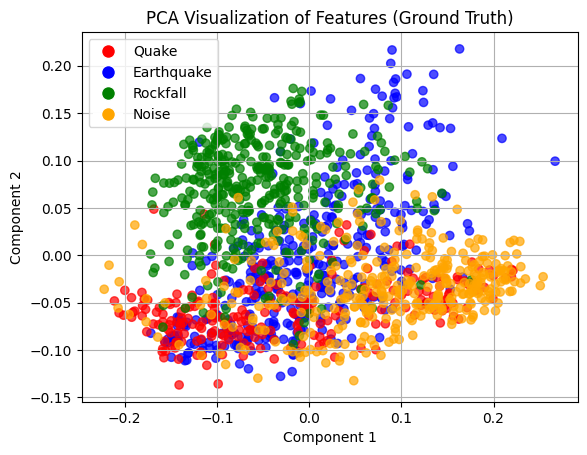

In [ ]:
visualize_2d_features(feature_reduced,title= '2-D PCA Visualization of Features (Ground Truth)')

<ipython-input-15-7428e52a5aae>:167: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(features_2d[:, 0], features_2d[:, 1], c=cluster_colors, cmap='viridis', alpha=0.7)


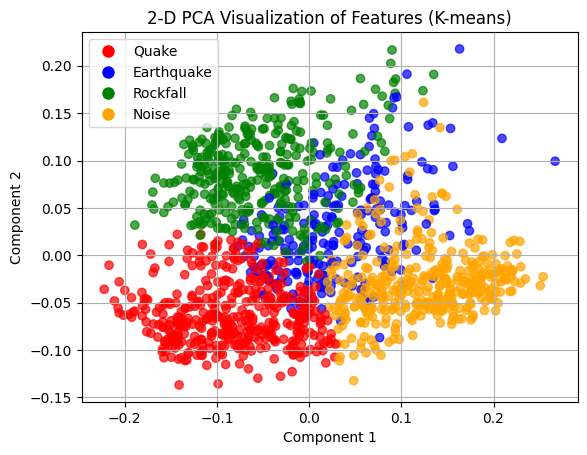

In [ ]:
visualize_2d_features(feature_reduced,clusters_true = post_assignments+1, title= '2-D PCA Visualization of Features (K-means)')

In [ ]:
import plotly.express as px
import pandas as pd

def visualize_3d_features(features_3d, clusters_true, title='PCA 3-D Visualization'):
    cluster_names = {
        1: 'Quake',
        2: 'Earthquake',
        3: 'Rockfall',
        4: 'Noise'
    }

    colors = ['red', 'blue', 'green', 'orange']

    # Create a DataFrame for plotly
    df = pd.DataFrame(features_3d, columns=['Component 1', 'Component 2', 'Component 3'])
    df['Cluster'] = clusters_true

    # Map cluster labels to cluster names
    df['Cluster'] = df['Cluster'].map(cluster_names)

    # Create a 3D scatter plot
    fig = px.scatter_3d(df, x='Component 1', y='Component 2', z='Component 3', color='Cluster',
                        color_discrete_map={name: color for name, color in zip(cluster_names.values(), colors)},
                        title=title)

    fig.show()

# Example usage
import numpy as np

# Dummy data for testing
features_3d = feature_reduced
clusters_true = y_train_raw.ravel()

visualize_3d_features(features_3d, clusters_true)

In [ ]:
from sklearn.manifold import TSNE

def visualize_tsne_3d(features, clusters_true, title='t-SNE 3-D Visualization'):
    cluster_names = {
        1: 'Quake',
        2: 'Earthquake',
        3: 'Rockfall',
        4: 'Noise'
    }

    colors = ['red', 'blue', 'green', 'orange']

    # Perform t-SNE reduction to 3D
    tsne = TSNE(n_components=3, random_state=42)
    features_3d = tsne.fit_transform(features)

    # Create a DataFrame for plotly
    df = pd.DataFrame(features_3d, columns=['Component 1', 'Component 2', 'Component 3'])
    df['Cluster'] = clusters_true

    # Map cluster labels to cluster names
    df['Cluster'] = df['Cluster'].map(cluster_names)

    # Create a 3D scatter plot
    fig = px.scatter_3d(df, x='Component 1', y='Component 2', z='Component 3', color='Cluster',
                        color_discrete_map={name: color for name, color in zip(cluster_names.values(), colors)},
                        title=title)

    fig.show()

# Dummy data for testing
features_3d = reshaped_features
clusters_true = y_train_raw.ravel()
#clusters_true = post_assignments+1

visualize_tsne_3d(features_3d, clusters_true)

In [ ]:
#t-sne
tsne = TSNE(n_components=3, random_state=42)
features_3d = tsne.fit_transform(reshaped_features)
cluster_assignments, cluster_centers = k_means_feature(feature_in = features_3d, y_test_raw = y_train_raw, k= 4)

In [ ]:
post_assignments = postprocess_label(cluster_assignments, y_test_raw = y_train_raw, x0=3, x1=2, x2=0, x3=1)

                  precision    recall  f1-score   support

           quake       0.42      0.67      0.52       234
      earthquake       0.85      0.62      0.72       389
        rockfall       0.88      0.85      0.87       402
enviroemnt noise       0.74      0.70      0.72       350

        accuracy                           0.72      1375
       macro avg       0.72      0.71      0.71      1375
    weighted avg       0.76      0.72      0.73      1375

[[156   8   4  66]
 [110 241  27  11]
 [ 24  24 343  11]
 [ 81   9  14 246]]
